In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import talib
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr, spearmanr
from statsmodels.regression.rolling import RollingOLS


import datetime
import time
import os
import pytz
import json
import csv

from pprint import pprint



In [2]:
# GLOBAL SETTINGS

# Data directories
#coin_dataDir = 'DATA/TESTDIR/' # Debug dir for testing I/O logic and/or issues. It should be a clone of the above dir.
coin_dataDir = 'DATA/COMBINEDDATA/'
plot_dataDir = 'DATA/INITIAL_INSIGHTS/MOMENTUM_FACTORS/'
model_dataDir = 'DATA/MODELDATA/'
riskFactor_dataDir = 'DATA/RISKFACTORSDATA/'



isdir = os.path.isdir(model_dataDir)

# Date ranges
START = 2019
END = 2022

MONTH = 30
YEAR = 12 * MONTH

# Helpers
idx = pd.IndexSlice
sns.set_style('whitegrid')

# END GLOBAL SETTINGS

In [3]:
# Read in MDF with initial coin pool
cpool_mdf = pd.read_csv(coin_dataDir + 'CoinPool.csv')
cpool_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
cpool_mdf['Dates'] = pd.to_datetime(cpool_mdf['Dates'])
cpool_mdf.set_index(['Dates', 'Coin'], inplace=True)
print('Initial Base Data:'.upper())


ohlcv = ['Open','High','Low','Close','Volume']
prices_mdf = (cpool_mdf
              .loc[idx[str(START):str(END), :], ohlcv]
              .swaplevel()
              .sort_index())

# want at least X years of data
yr = 3
min_obs = yr * YEAR

# have this much per ticker
nobs = prices_mdf.groupby(level='Coin').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices_mdf = prices_mdf.loc[idx[keep, :], :]
print(f"After dropping coins with less than {yr} years of data".upper())

INITIAL BASE DATA:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8118 entries, (Timestamp('2018-08-24 00:00:00'), 'binancecoin') to (Timestamp('2022-02-17 00:00:00'), 'uniswap')
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        8118 non-null   float64
 1   High        8118 non-null   float64
 2   Low         8118 non-null   float64
 3   Close       8118 non-null   float64
 4   Volume      8118 non-null   float64
 5   Market Cap  8118 non-null   float64
dtypes: float64(6)
memory usage: 447.0+ KB
None
AFTER DROPPING COINS WITH LESS THAN 3 YEARS OF DATA
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5720 entries, ('binancecoin', Timestamp('2019-01-01 00:00:00')) to ('ripple', Timestamp('2022-02-17 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5720 non-null   float64
 1   High    5720 non-null   float64
 2   Low     572

In [5]:
# Compute Technical Analysis Indicators to be use as momentum alpha factors (The Features)

# Relative Strength Index (RSI)
prices_mdf['RSI'] = prices_mdf.groupby(level='Coin').Close.apply(talib.RSI)

# Bollinger Bands
def compute_bb(close):
    high, mid, low = talib.BBANDS(close, timeperiod=20)
    return pd.DataFrame({'BB_high': high, 'BB_low': low}, index=close.index)

prices_mdf = (prices_mdf.join(prices_mdf
                      .groupby(level='Coin')
                      .Close
                      .apply(compute_bb)))

# Average True Range (ATR)
def compute_atr(coin_data):
    df = talib.ATR(coin_data.High, coin_data.Low,
             coin_data.Close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

prices_mdf['ATR'] = (prices_mdf.groupby('Coin', group_keys=False)
                 .apply(compute_atr))

# Moving Average Convergence Divergence (MACD)
def compute_macd(close):
    macd = talib.MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

prices_mdf['MACD'] = (prices_mdf
                  .groupby('Coin', group_keys=False)
                  .Close
                  .apply(compute_macd))


# Stochastic Oscillator (STOCH)
def compute_stoch(coin_data):
    slowk, slowd = talib.STOCH(coin_data.High,
                         coin_data.Low,
                         coin_data.Close,
                         fastk_period=14,
                         slowk_period=3,
                         slowk_matype=0,
                         slowd_period=3,
                         slowd_matype=0)

    return slowd/slowk

prices_mdf['STOCH'] = (prices_mdf
                       .groupby('Coin', group_keys=False)
                       .apply(compute_stoch))

# Average Directional Index (ADX)
def compute_adx(coin_data):
    real = talib.ADX(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

prices_mdf['ADX'] = (prices_mdf
                     .groupby('Coin', group_keys=False)
                     .apply(compute_adx))


#Plus/Minus Directional Index
def compute_diplus(coin_data):
    real = talib.PLUS_DI(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

def compute_diminus(coin_data):
    real = talib.MINUS_DI(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

prices_mdf["DI_PLUS"] = (prices_mdf.groupby('Coin', group_keys=False).apply(compute_diplus))
prices_mdf["DI_MINUS"] = (prices_mdf.groupby('Coin', group_keys=False).apply(compute_diminus))

# Compute lagged returns and Winsorize
lags = [1, 7, 14, 30, 60, 90]

q = 0.0001

for lag in lags:
    prices_mdf[f'return_{lag}d'] = (prices_mdf.groupby(level='Coin').Close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )
# Shift lagged returns
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 7, 14, 30, 60, 90]:

        prices_mdf[f'return_{lag}d_lag{t}'] = (prices_mdf.groupby(level='Coin')
                                           [f'return_{lag}d'].shift(t * lag))

# Generate target forward returns
for t in [1, 7, 14, 30, 60, 90]:

    prices_mdf[f'target_{t}d'] = prices_mdf.groupby(level='Coin')[f'return_{t}d'].shift(-t)

# Create dummy time variables. USe drop first to avoid creating multicollinearity.
prices_mdf['year'] = prices_mdf.index.get_level_values('Dates').year
prices_mdf['month'] = prices_mdf.index.get_level_values('Dates').month

prices_mdf = pd.get_dummies(prices_mdf,
                        columns=['year', 'month'],
                        prefix=['year', 'month'],
                        prefix_sep=['_', '_'],
                        drop_first=True)


# Read in PCA Risk Factors
risk_factors_df = pd.read_csv(riskFactor_dataDir + 'PCA_Risk_Factors.csv')
risk_factors_df.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
risk_factors_df['Dates'] = risk_factors_df['Dates'].astype('datetime64')
risk_factors_df = risk_factors_df.set_index('Dates')
risk_factors_df.drop(risk_factors_df.index[-1], inplace=True)

# Combine them with daily returns
daily_returns = prices_mdf.loc[:, 'return_1d':'return_90d']
factor_betas = daily_returns.join(risk_factors_df).sort_index()

# Get rid of the extra returns
del factor_betas['return_7d']
del factor_betas['return_14d']
del factor_betas['return_30d']
del factor_betas['return_60d']
del factor_betas['return_90d']

# Compute the factor Betas with Rolling OLS Regression on the PCA Principal Componenets
T = 30
betas = (factor_betas.groupby(level='Coin',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1d,
                                     exog=sm.add_constant(x.drop('return_1d', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))


factors = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3',
           'Principal Component 4']

# Impute missing Betas
betas = betas.loc[:, factors] = betas.groupby('Coin')[factors].apply(lambda x: x.fillna(x.mean()))
print("Factos Betas:".upper())
print(betas.describe().join(betas.sum(1).describe().to_frame('total')))

# Combine the Factor Betas with the rest of the model
prices_mdf = (prices_mdf
        .join(betas
              .groupby(level='Coin')
              .shift()))

# Immpute the missing factor betas to fill things out
prices_mdf.loc[:, factors] = prices_mdf.groupby('Coin')[factors].apply(lambda x: x.fillna(x.mean()))
print("Features so far".upper())

FACTOS BETAS:
       Principal Component 1  Principal Component 2  Principal Component 3  \
count            5720.000000            5720.000000            5720.000000   
mean                0.488923              -0.021531              -0.060801   
std                 0.108621               0.512503               0.490958   
min                 0.188873              -1.746682              -1.408664   
25%                 0.442337              -0.184820              -0.400345   
50%                 0.471212               0.002879              -0.267424   
75%                 0.537536               0.248282              -0.006034   
max                 0.976355               1.714336               1.433380   

       Principal Component 4        total  
count            5720.000000  5720.000000  
mean                0.005016     0.411606  
std                 0.513687     0.908494  
min                -1.121455    -1.653500  
25%                -0.483559    -0.357519  
50%                

In [ ]:
# Debugging Purposes
#prices_mdf.info()
#prices_mdf.columns
#prices_mdf

In [7]:
# Save the model data
if isdir == False:
    os.makedirs(model_dataDir)
    print("Directory '% s' created" % model_dataDir)
    prices_mdf.to_hdf(f'{model_dataDir}model_data.h5', 'model_data')
    prices_mdf.to_csv(f'{model_dataDir}ModelData.csv')
    print(f"The model data has been saved to {model_dataDir} as a MultiIndex dataframe")

else:
    prices_mdf.to_csv(f'{model_dataDir}ModelData.csv')
    prices_mdf.to_hdf(f'{model_dataDir}model_data.h5', 'model_data')
    print(f"The model data has been saved to {model_dataDir} as a MultiIndex dataframe")



The model data has been saved to DATA/MODELDATA/ as a MultiIndex dataframe


Coins with Unique Values:
5


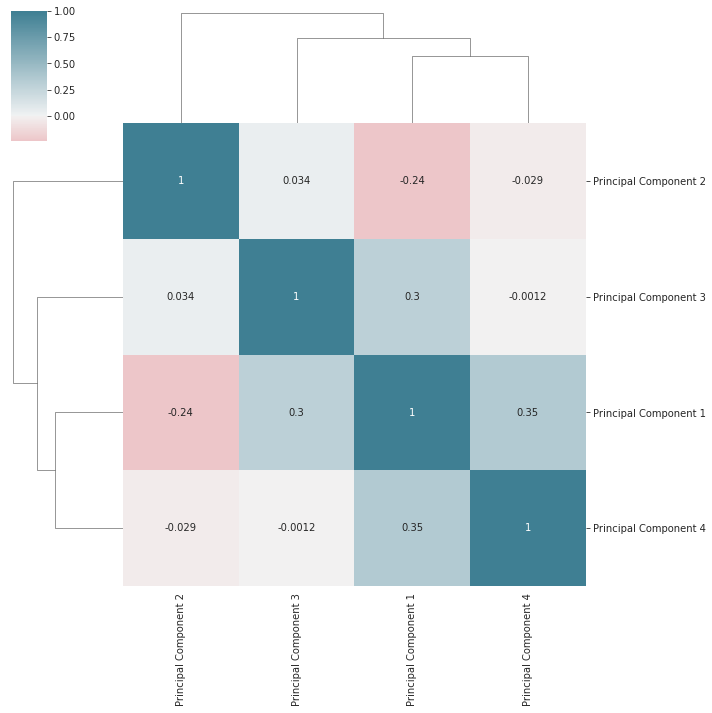

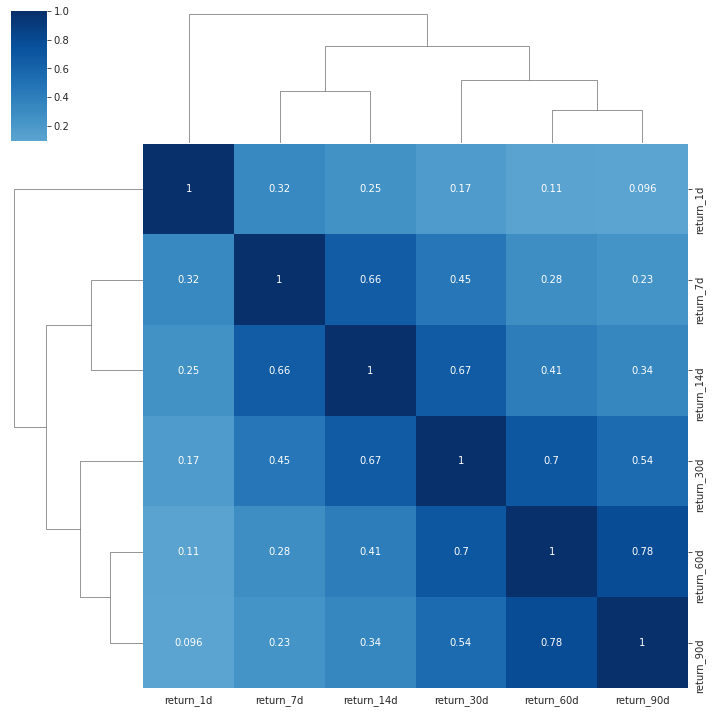

In [9]:
# DATASET INSIGHTS AND VISUALIZATION PLOTS

# Plot correlation custermap of the Betas
cmap = sns.diverging_palette(10, 220, as_cmap=True)
beta_cmap = sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0)

# Correlation Cluster map of the Returns
returns = prices_mdf.loc[:, 'return_1d':"return_90d"]
clusterMap = sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap='Blues')
print('Coins with Unique Values:')
print(returns.index.get_level_values('Coin').nunique())

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


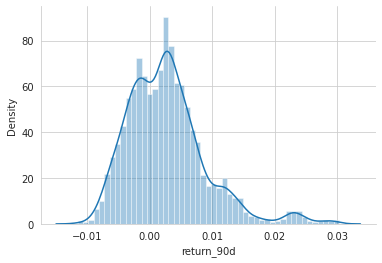

In [11]:
# Check return distributions

sns_distPlot = sns.distplot(returns['return_90d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


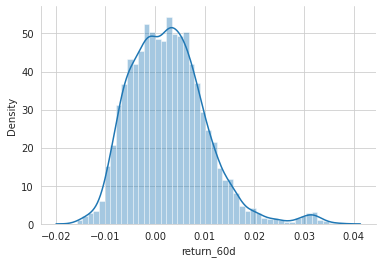

In [12]:
sns_distPlot = sns.distplot(returns['return_60d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


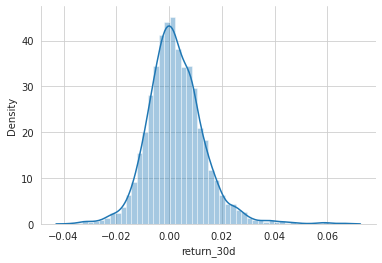

In [13]:
sns_distPlot = sns.distplot(returns['return_30d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


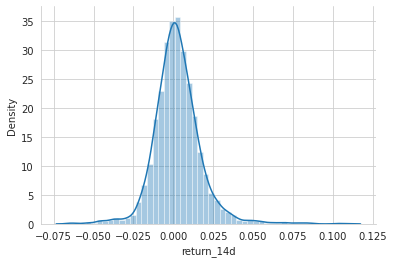

In [14]:
sns_distPlot = sns.distplot(returns['return_14d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


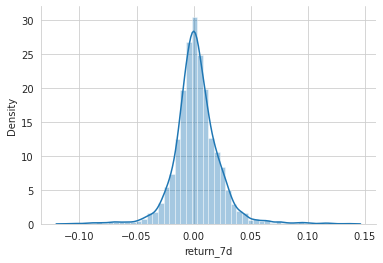

In [15]:
sns_distPlot = sns.distplot(returns['return_7d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


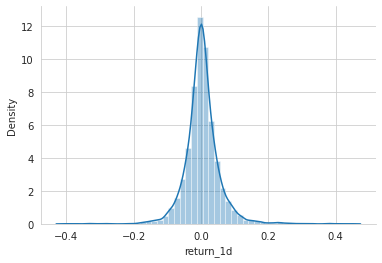

In [16]:
sns_distPlot = sns.distplot(returns['return_1d'])
fig = sns_distPlot.get_figure()
sns.despine()

Daily Returns Spearman
-8.73% (0.00%)


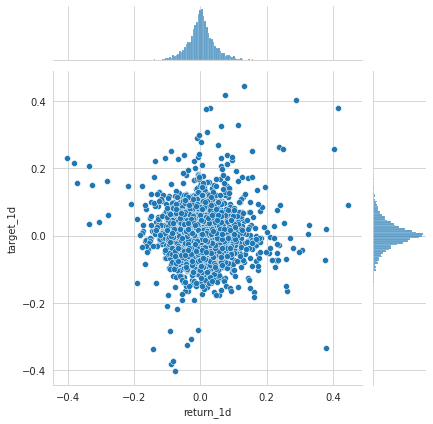

In [18]:
# Spearman Ranks and scatter plots for factors
target = 'target_7d'
price_copy = prices_mdf.copy()

# Daily Returns
daily_target = "target_1d"
metric = 'return_1d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Daily Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')


Weekly Returns Spearman
3.40% (1.07%)


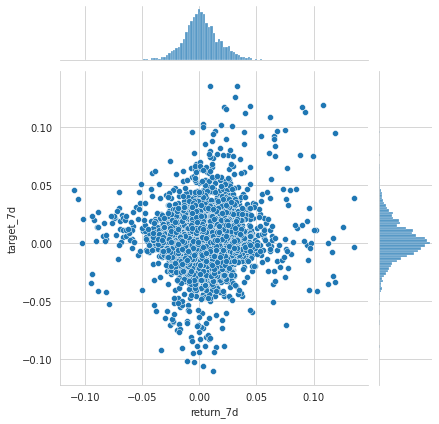

In [19]:
# Weekly Returns
daily_target = "target_7d"
metric = 'return_7d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Weekly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Bi-Weekly Returns Spearman
11.85% (0.00%)


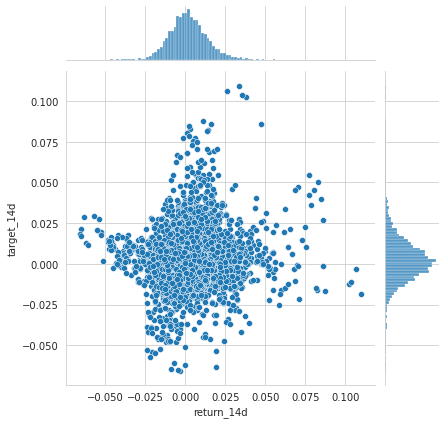

In [20]:
# Bi-Weekly Returns
daily_target = "target_14d"
metric = 'return_14d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Bi-Weekly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Monthly Returns Spearman
7.33% (0.00%)


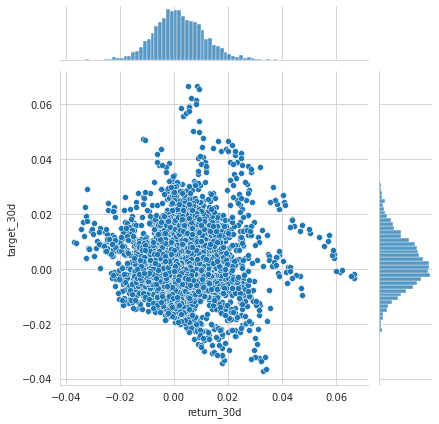

In [21]:
# Monthly Returns
daily_target = "target_30d"
metric = 'return_30d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Monthly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Bi-Monthly Returns Spearman
-4.63% (0.09%)


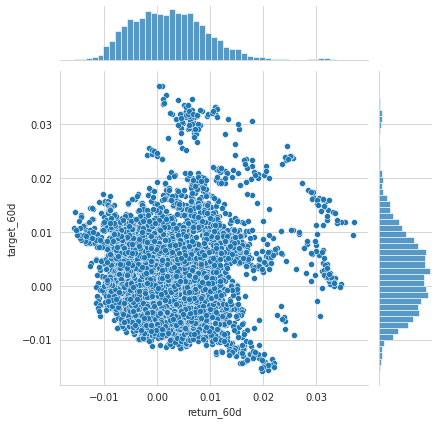

In [22]:
# Bi-Monthly Returns
daily_target = "target_60d"
metric = 'return_60d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Bi-Monthly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Three Month Returns Spearman
-9.77% (0.00%)


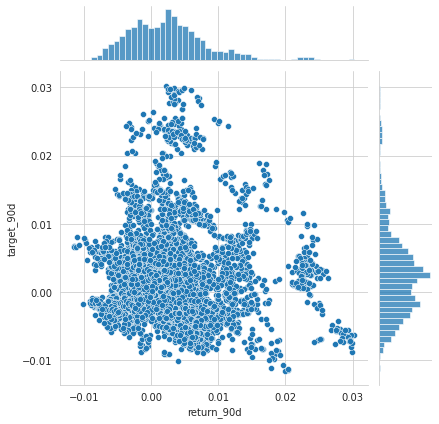

In [23]:
# Three Month Returns
daily_target = "target_90d"
metric = 'return_90d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Three Month Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Daily RETURNS FEATURE INFO
RSI Distributions
             count      mean       std       min       25%       50%       75%       max
rsi_signal                                                                              
(0, 30]      164.0  0.005050  0.016776 -0.066810 -0.000519  0.004706  0.013363  0.045421
(30, 70]    4823.0  0.001884  0.019202 -0.109671 -0.007736  0.001160  0.011339  0.135509
(70, 100]    628.0  0.008347  0.026680 -0.072761 -0.007418  0.003873  0.019342  0.135180
RSI Spearman
8.48% (0.00%)


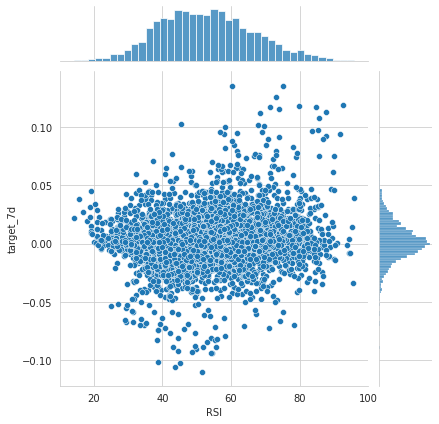

In [24]:
# Relative Strength Index (RSI)
print("Daily RETURNS FEATURE INFO")
price_copy.loc[:, 'rsi_signal'] = pd.cut(price_copy.RSI, bins=[0, 30, 70, 100])
print("RSI Distributions")
print(price_copy.groupby('rsi_signal')['target_7d'].describe().to_string())

metric = "RSI"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("RSI Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)


ADX FEATURE INFO
ADX Distributions
             count      mean       std       min       25%       50%       75%       max
adx_signal                                                                              
(0, 25]     2192.0  0.002180  0.019384 -0.101975 -0.007724  0.001098  0.011311  0.116878
(25, 50]    3019.0  0.003318  0.020529 -0.109671 -0.006978  0.002277  0.012875  0.135509
(50, 75]     339.0  0.002029  0.023736 -0.072761 -0.009413  0.000787  0.011367  0.118970
(75, 100]      0.0       NaN       NaN       NaN       NaN       NaN       NaN       NaN
ADX Spearman
4.63% (0.06%)


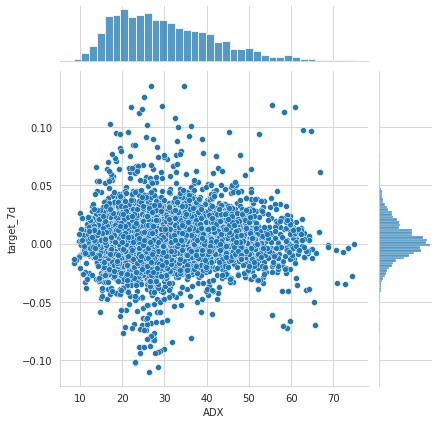

In [25]:
# Average Directional Moving Index (ADX)
print("ADX FEATURE INFO")
price_copy.loc[:, 'adx_signal'] = pd.cut(price_copy.ADX, bins=[0, 25, 50, 75, 100])
print("ADX Distributions")
print(price_copy.groupby('adx_signal')['target_7d'].describe().to_string())

metric = "ADX"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("ADX Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)



DI Plus Spearman
5.87% (0.00%)


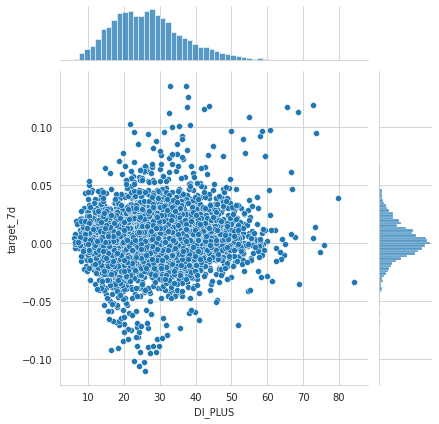

In [26]:
# Directional Indices (DM+/-)
metric = "DI_PLUS"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("DI Plus Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

DI Minus Spearman
-7.53% (0.00%)


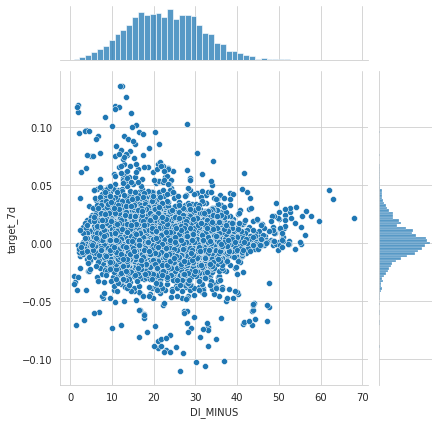

In [27]:
metric = "DI_MINUS"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("DI Minus Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

Lower BB Spearman
0.81% (54.55%)


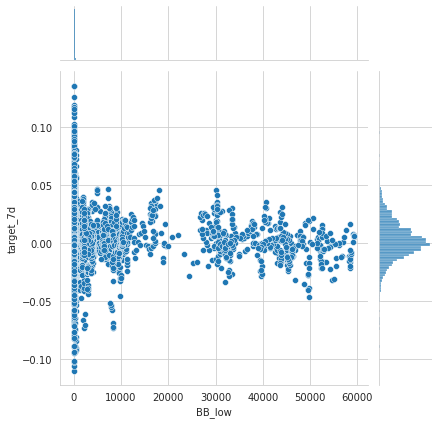

In [28]:
# Bollinger Bands
metric = 'BB_low'
df = price_copy[[metric, target]].dropna()
j=sns.jointplot(x=df[metric], y=df[target], data=df)
r, p = spearmanr(df[metric], df[target])
print("Lower BB Spearman")
print(f'{r:,.2%} ({p:.2%})')


Upper BB Spearman
1.00% (45.67%)


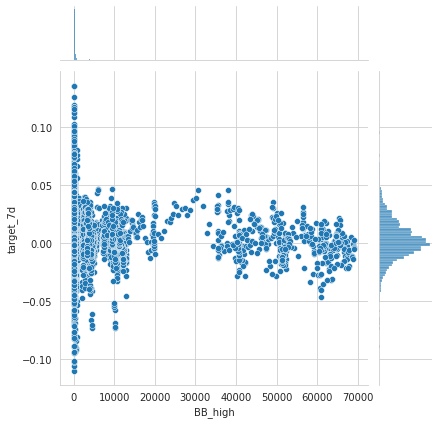

In [29]:
metric = 'BB_high'
df = price_copy[[metric, target]].dropna()
j=sns.jointplot(x=df[metric], y=df[target], data=df)
r, p = spearmanr(df[metric], df[target])
print("Upper BB Spearman")
print(f'{r:,.2%} ({p:.2%})')

ATR Spearman
-8.11% (0.00%)


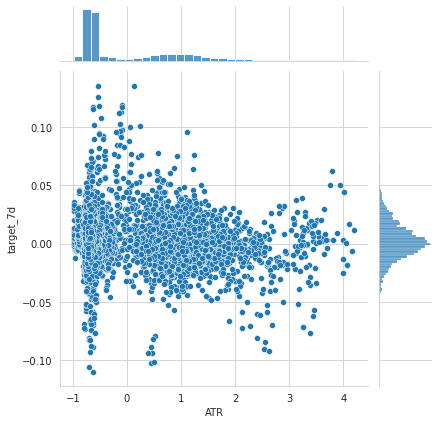

In [30]:
# Active True Range (ATR)
metric = 'ATR'
j=sns.jointplot(x=metric, y=target, data=price_copy)
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("ATR Spearman")
print(f'{r:,.2%} ({p:.2%})')

MACD Spearman
7.83% (0.00%)


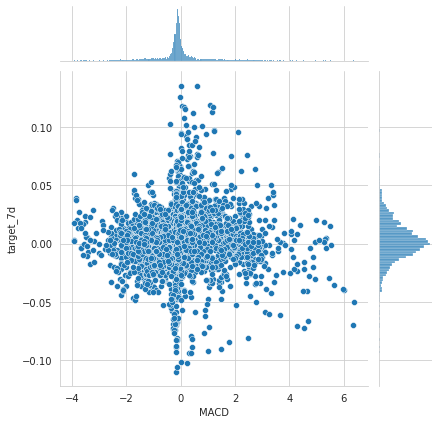

In [31]:
# Moving Average Convegeance Divergeance (MACD)
metric = 'MACD'
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("MACD Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

STOCH Spearman
-0.80% (55.19%)


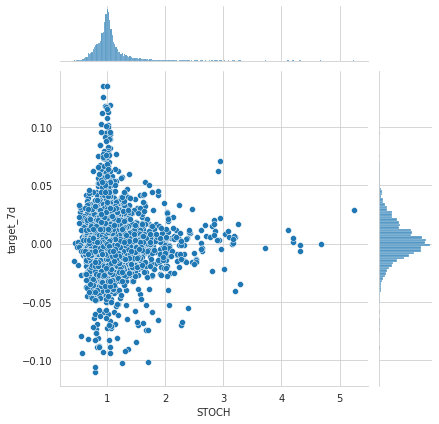

In [32]:
# Stochastic Oscillator
metric = 'STOCH'
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("STOCH Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

In [33]:
# Distribution plots and statistics
print("RETURNS PERCENTILES")
returns = prices_mdf.groupby(level='Coin').Close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
print(returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles'))

RETURNS PERCENTILES
        percentiles
std        0.052303
min       -0.429773
0.01%     -0.401935
0.1%      -0.312750
1%        -0.128751
50%        0.001884
99%        0.164426
99.9%      0.341834
99.99%     0.446229
max        0.485204


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


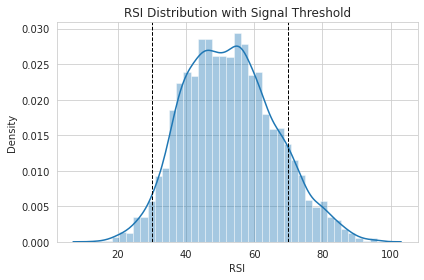

In [34]:
# RSI distplot
RSI_ax = sns.distplot(prices_mdf.RSI.dropna())
RSI_ax.axvline(30, ls='--', lw=1, c='k')
RSI_ax.axvline(70, ls='--', lw=1, c='k')
RSI_ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


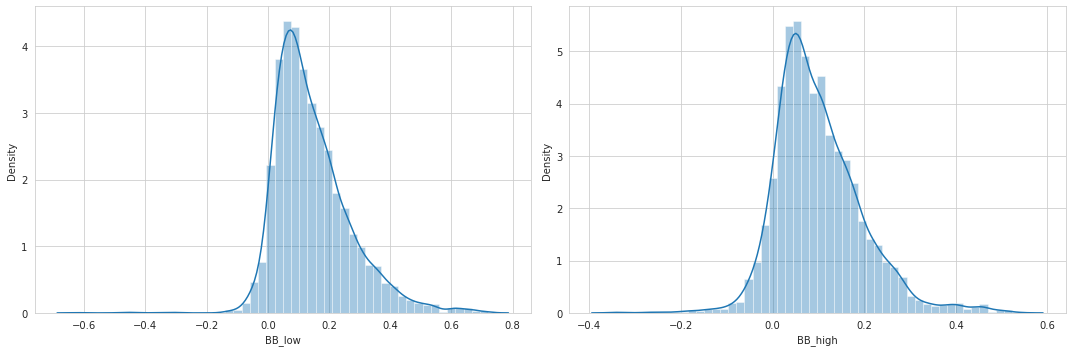

In [35]:
# Bollinger Bands distplot
prices_mdf['BB_high'] = prices_mdf.BB_high.sub(prices_mdf.Close).div(prices_mdf.BB_high).apply(np.log1p)
prices_mdf['BB_low'] = prices_mdf.Close.sub(prices_mdf.BB_low).div(prices_mdf.Close).apply(np.log1p)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices_mdf.BB_low.dropna(), ax=axes[0])
sns.distplot(prices_mdf.BB_high.dropna(), ax=axes[1])
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


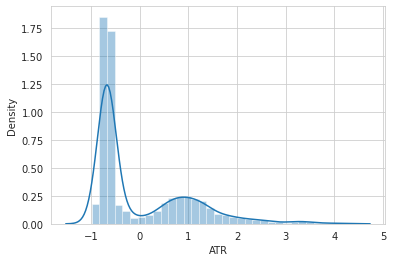

In [36]:
# Average True Range
atr_plot = sns.distplot(prices_mdf.ATR.dropna())
fig = atr_plot.get_figure()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MACD Percentiles
count    5,555.0
mean        -0.0
std          1.0
min         -3.9
0.1%        -3.8
1%          -2.5
2%          -2.2
3%          -1.9
4%          -1.7
5%          -1.5
50%         -0.1
95%          2.0
96%          2.2
97%          2.5
98%          2.8
99%          3.4
99.9%        5.5
max          6.4
Name: MACD, dtype: object


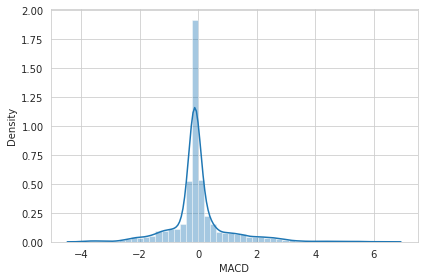

In [37]:
# MACD distribution
print("MACD Percentiles")
print(prices_mdf
      .MACD
      .describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999])
      .apply(lambda x: f'{x:,.1f}'))

MACD_dist = sns.distplot(prices_mdf.MACD.dropna())
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'ADX Distribution with Signal Threshold')

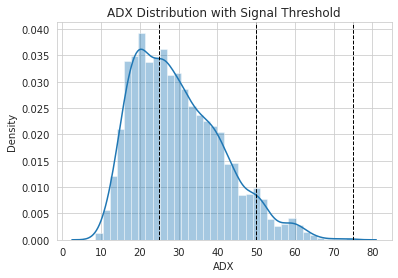

In [38]:
# ADX distribution plot
ADX_dist = sns.distplot(prices_mdf.ADX.dropna())
ADX_dist.axvline(25, ls='--', lw=1, c='k')
ADX_dist.axvline(50, ls='--', lw=1, c='k')
ADX_dist.axvline(75, ls='--', lw=1, c='k')
ADX_dist.set_title('ADX Distribution with Signal Threshold')

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


STOCH percentiles
count    5,635.0
mean         1.1
std          0.3
min          0.4
0.1%         0.5
1%           0.6
2%           0.7
3%           0.7
4%           0.7
5%           0.7
50%          1.0
95%          1.6
96%          1.7
97%          1.8
98%          2.0
99%          2.3
99.9%        4.1
max          5.3
Name: STOCH, dtype: object


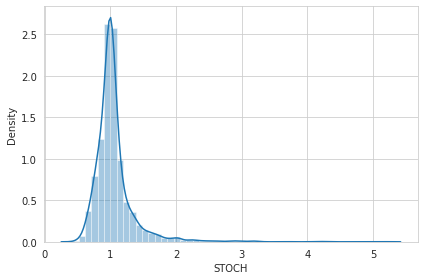

In [39]:
# Stochastic Oscillator distplot
print("STOCH percentiles")
print(prices_mdf
      .STOCH
      .describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999])
      .apply(lambda x: f'{x:,.1f}'))



STOCH_ax = sns.distplot(prices_mdf.STOCH.dropna())
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


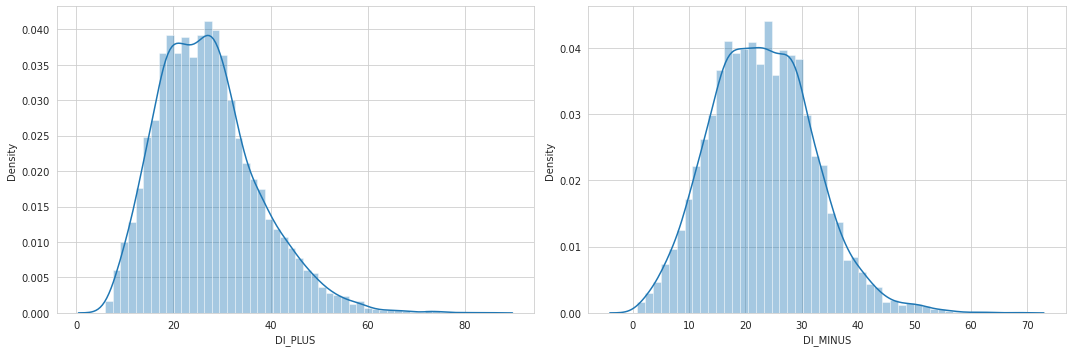

In [40]:
# Directional Indicators (DI +/-)
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices_mdf.DI_PLUS.dropna(), ax=axes[0])
sns.distplot(prices_mdf.DI_MINUS.dropna(), ax=axes[1])
plt.tight_layout()

In [43]:
# Impute missing returns
daily_avg = prices_mdf.loc[:,'return_1d':'return_90d'].mean(1)
prices_mdf.loc[:,'return_1d':'return_90d'] = prices_mdf.loc[:,'return_1d':'return_90d'].apply(lambda x: x.fillna(daily_avg))
#prices_mdf.loc[:,'return_1d':'return_90d']

# Impute missing forward returns
daily_avg = prices_mdf.loc[:,'target_1d':'target_90d'].mean(1)
prices_mdf.loc[:,'target_1d':'target_90d'] = prices_mdf.loc[:,'target_1d':'target_90d'].apply(lambda x: x.fillna(daily_avg))
#prices_mdf.loc[:,'target_1d':'target_90d']

#Impute missing TA indicator values (Doesn't work yet..)
daily_avg = prices_mdf.loc[:,'RSI':'DI_MINUS'].mean(1)
prices_mdf.loc[:,'RSI':'DI_MINUS'] = prices_mdf.loc[:,'RSI':'DI_MINUS'].apply(lambda x: x.fillna(daily_avg))

# Impute Missing lag periods
daily_avg =prices_mdf.loc[:,'return_1d_lag1':'return_90d_lag5'].mean(1)
prices_mdf.loc[:,'return_1d_lag1':'return_90d_lag5'] = prices_mdf.loc[:,'return_1d_lag1':'return_90d_lag5'].apply(lambda x: x.fillna(daily_avg))

In [44]:
# THIS IS THE LINE THAT MAKES EVERYTHING DROP FROM 2019
# THIS IS PROBABLY BECAUSE OF THE  LAG PERIODS
prices_mdf = (prices_mdf
            .dropna()
            .drop(['Open', 'Close', 'Low', 'High', 'Volume'], axis=1))

In [45]:
prices_mdf

RSI    BB_high     BB_low       ATR       MACD  \
Coin        Dates                                                              
binancecoin 2019-01-15  48.256284  23.282327  23.282327 -0.694342  23.282327   
            2019-01-16  50.970067  24.081559  24.081559 -0.694807  24.081559   
            2019-01-17  57.460700  26.240895  26.240895 -0.694855  26.240895   
            2019-01-18  56.940314  21.515985  21.515985 -0.695114  21.515985   
            2019-01-19  62.085097  21.954052  21.954052 -0.695040  21.954052   
...                           ...        ...        ...       ...        ...   
ripple      2022-02-12  60.255567   0.073619   0.345865  0.509790   0.584464   
            2022-02-13  56.311026   0.114961   0.321397  0.506261   0.589269   
            2022-02-14  59.102731   0.097115   0.332386  0.487743   0.637490   
            2022-02-15  60.161543   0.096067   0.327584  0.444667   0.687389   
            2022-02-16  58.636644   0.114272   0.310535  0.406810   0.699381   

                            STOCH        ADX    DI_PLUS   DI_MINUS  return_1d  \
Coin        Dates                                                               
binancecoin 2019-01-15  23.282327  23.282327  21.809120  23.758247   0.000591   
            2019-01-16  24.081559  24.081559  23.637018  22.413956   0.019887   
            2019-01-17  26.240895  26.240895  27.440342  20.757396   0.052676   
            2019-01-18   0.809514  21.515985  31.109921  19.415288  -0.003208   
            2019-01-19   0.812394  21.954052  29.676296  17.891515   0.044774   
...                           ...        ...        ...        ...        ...   
ripple      2022-02-12   1.074153  36.791659  31.362368  22.904528   0.066005   
            2022-02-13   1.048864  35.276943  29.194804  21.321515  -0.038100   
            2022-02-14   0.967943  33.806970  27.468770  20.429070   0.038352   
            2022-02-15   0.969562  32.839460  29.520677  19.573334   0.014265   
            2022-02-16   0.970181  31.714307  28.200488  19.969522  -0.013119   

                        ...  month_7  month_8  month_9  month_10  month_11  \
Coin        Dates       ...                                                  
binancecoin 2019-01-15  ...        0        0        0         0         0   
            2019-01-16  ...        0        0        0         0         0   
            2019-01-17  ...        0        0        0         0         0   
            2019-01-18  ...        0        0        0         0         0   
            2019-01-19  ...        0        0        0         0         0   
...                     ...      ...      ...      ...       ...       ...   
ripple      2022-02-12  ...        0        0        0         0         0   
            2022-02-13  ...        0        0        0         0         0   
            2022-02-14  ...        0        0        0         0         0   
            2022-02-15  ...        0        0        0         0         0   
            2022-02-16  ...        0        0        0         0         0   

                        month_12  Principal Component 1  \
Coin        Dates                                         
binancecoin 2019-01-15         0               0.486209   
            2019-01-16         0               0.486209   
            2019-01-17         0               0.486209   
            2019-01-18         0               0.486209   
            2019-01-19         0               0.486209   
...                          ...                    ...   
ripple      2022-02-12         0               0.484369   
            2022-02-13         0               0.487099   
            2022-02-14         0               0.486024   
            2022-02-15         0               0.487225   
            2022-02-16         0               0.491044   

                        Principal Component 2  Principal Component 3  \
Coin        Dates                                                      
binancec

In [ ]:
# Mutual Information of the Data
target_labels = [f'target_{i}d' for i in [1,7,14,30,60,90]]
targets = prices_mdf.dropna().loc[:, target_labels]

features = prices_mdf.dropna().drop(labels=target_labels, axis=1)
#print(features.columns)
cat_cols = ['year_2020','year_2021','year_2022', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

In [ ]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [ ]:
mutual_info.sum()

In [ ]:
# Normalized Mutual Information(MI) Heatmap
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

In [ ]:
dummy_data = pd.get_dummies(prices_mdf,
                            columns=['year_2020','year_2021','year_2022', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

In [ ]:
# Dummy Data
target_labels = [f'target_{i}d' for i in [1,7,14,30,60,90]]

dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [ ]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [ ]:
mutual_info_dummies.sum()

In [ ]:
# Dummy Normalized Mutual Information(MI) Heatmap
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');

In [ ]:
prices_mdf